In [1]:
from multiConceptPipeline import MultiPrompt2PromptPipeline
import torch 
import numpy as np
from attentionControlMulti import AttentionSwap
from utils import view_images


In [4]:
# 基础模型位置
model_path = "/home/ld_xu/myproject/stable-diffusion-v1-4"
# custom模型位置
custom_path = "/home/ld_xu/myproject/multi/cat_wooden_pot/500"

device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')

pipe = MultiPrompt2PromptPipeline.from_pretrained(model_path).to(device)
pipe.load_textual_inversion(custom_path, weight_name="_new1_.bin")
pipe.load_textual_inversion(custom_path, weight_name="_new2_.bin")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------------
Successfull to load the Custom Diffusion Modle Weight from file:/home/ld_xu/myproject/multi/cat_wooden_pot/500
----------------------------------------------------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ld_xu/myproject/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:567: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


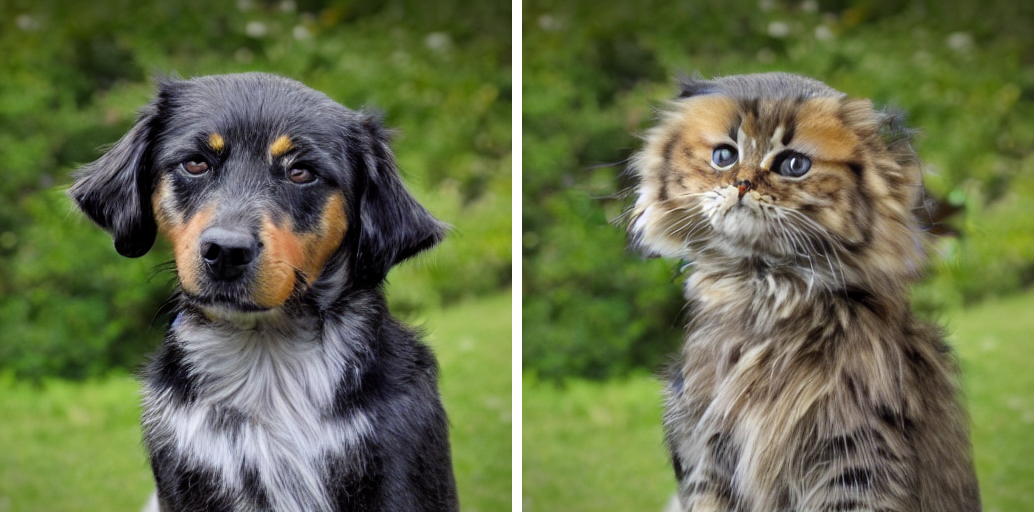

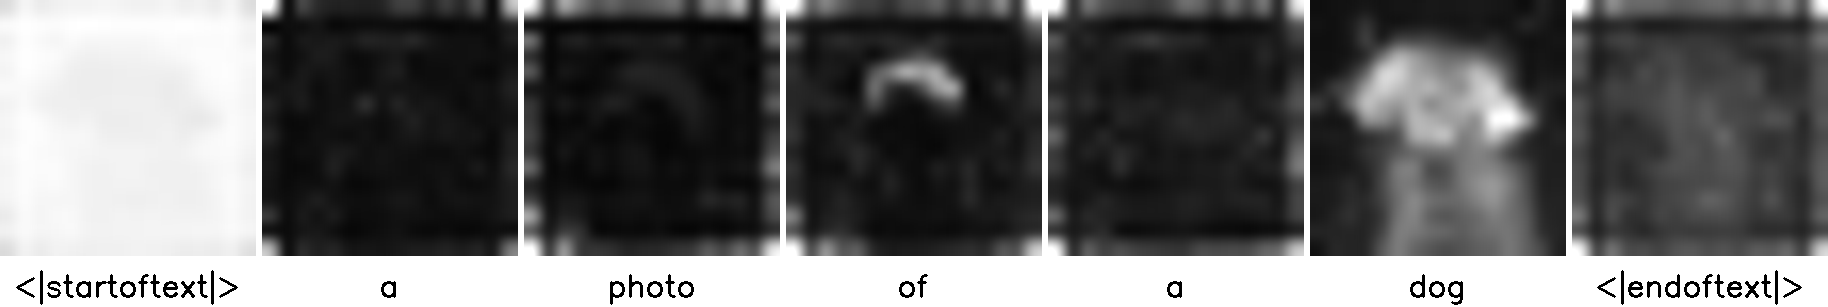

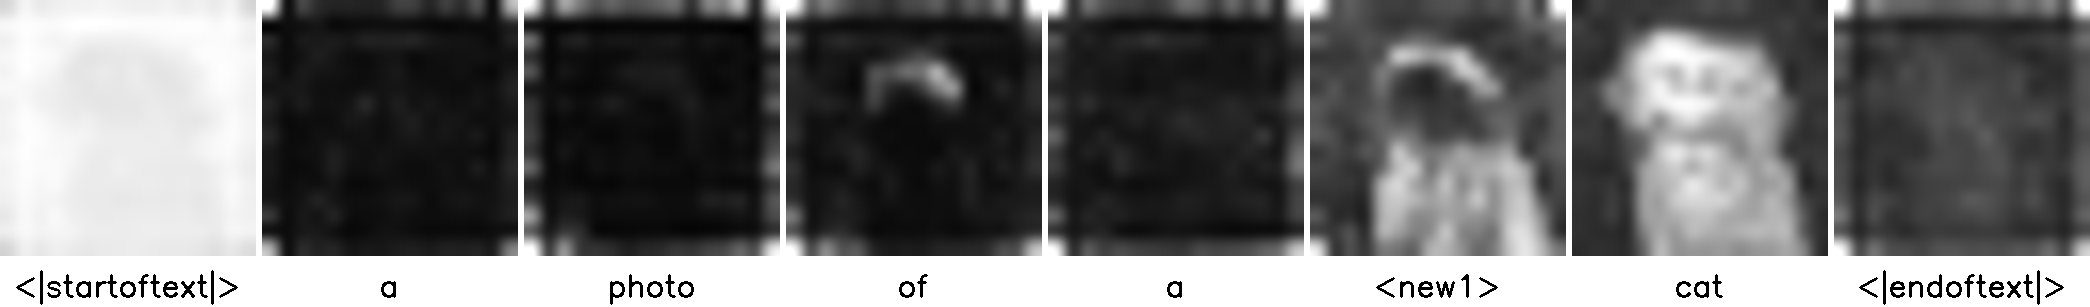

In [5]:
# prompts = ["A cat stands next to the pot",
#            "A <new1> cat stands next to the <new2> pot"]

prompts = ["A photo of a dog",
           "A photo of a <new1> cat"]
g_cpu = torch.Generator().manual_seed(5837)

NUM_DIFFUSION_STEPS = 50
source_subject_word = 'dog'
target_subject_word = '<new1>'

source_substruct_words = 'pot'
target_substruct_words = '<new2>'

# source_subject_word = 'dog'
# target_subject_word = '<new1>'

# source_substruct_words = None
# target_substruct_words = None

# sustract_words = (((source_substruct_words,), (target_substruct_words,)))
sustract_words = None
controller = AttentionSwap(prompts, NUM_DIFFUSION_STEPS, 
                            cross_map_replace_steps=.7,
                            self_map_replace_steps=.3,
                            self_output_replace_steps=.2,
                            tokenizer=pipe.tokenizer,
                            device=pipe.device,
                            source_subject_word=source_subject_word, 
                            target_subject_word=target_subject_word,
                            substruct_words=sustract_words,
                            )

outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu, guidance_scale = 6.0, ModelPath = custom_path)

view_images( [np.array(img) for img in outputs.images] )

pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)

